In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Grid Search

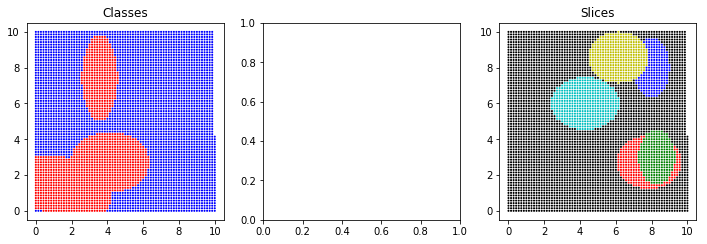

In [2]:
from torch.utils.data import DataLoader

from metal.utils import SlicingDataset
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset
from metal.utils import split_data
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

NUM_TRIALS = 20
NUM_SLICES = 5
K = 2
M = 20
N = 5000
unipolar = True
seed = None

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, targeting_lfs_idx = generate_dataset(K, M, N, 
                                                 Z_kwargs=Z_kwargs,
                                                 unipolar=unipolar,
                                                 return_targeting_lfs=True,
                                                 seed=seed)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

In [3]:
label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Y_train = label_model.predict_proba(Ls[0])
Ys[0] = Y_train

label_model.score((Ls[1], Ys[1]))

Accuracy: 0.634
        y=1    y=2   
 l=1    231    349   
 l=2    108    562   


0.6344

In [4]:
layer_out_dims = [2, 10, 10, 2]
search_space = {
    'n_epochs': [20],
    'lr': [0.01],
    'l2': [1e-7], #{'range': [1e-7, 1e-3], 'scale': 'log'},
    'slice_weight': [0.1],
    # 'batch_size': None <-- This is handled in DataLoader
}

In [5]:
import torch
from torch.utils.data import DataLoader

from metal.tuners import RandomSearchTuner
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.utils import SlicingDataset
from metal.end_model import EndModel

batch_size = 32
L_train = torch.Tensor(Ls[0].todense())
train_dataset = SlicingDataset(Xs[0], L_train, Ys[0])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
end_model = EndModel(layer_out_dims, verbose=False)

tuner = RandomSearchTuner(SliceHatModel, log_dir='checkpoints')
best_model = tuner.search(
    search_space,
    dev_data=(Xs[1], Ys[1]),
    max_search=10,
    init_args=[end_model, M],
    init_kwargs={'verbose': False},
    train_args=[train_loader],
    train_kwargs={'verbose': True, 'disable_prog_bar': True, 'print_every': 5},
    verbose=True,
)

[0] Testing {'n_epochs': 20, 'lr': 0.01, 'l2': 1e-07, 'slice_weight': 0.1}


/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/torch/nn/_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Saving model at iteration 0 with best score 0.647
[E:0]	Train Loss: 0.624	Dev accuracy: 0.647
Saving model at iteration 1 with best score 0.698
Saving model at iteration 2 with best score 0.788
Saving model at iteration 3 with best score 0.790
[E:5]	Train Loss: 0.620	Dev accuracy: 0.762
[E:10]	Train Loss: 0.620	Dev accuracy: 0.724
Saving model at iteration 14 with best score 0.818
[E:15]	Train Loss: 0.620	Dev accuracy: 0.746
Saving model at iteration 16 with best score 0.842
Saving model at iteration 18 with best score 0.858
[E:19]	Train Loss: 0.620	Dev accuracy: 0.828
Restoring best model from iteration 18 with score 0.858
Finished Training
Accuracy: 0.858
        y=1    y=2   
 l=1    270    109   
 l=2    69     802   
[SUMMARY]
Best model: [0]
Best config: {'n_epochs': 20, 'lr': 0.01, 'l2': 1e-07, 'slice_weight': 0.1}
Best score: 0.8576


In [6]:
from metal.contrib.slicing.experiment_utils import eval_model
from metal.contrib.slicing.experiment_utils import parse_history

test_dataset = SlicingDataset(Xs[2], Ys[2], Zs[2])
test_loader = DataLoader(test_dataset)

results = eval_model(best_model, test_loader, verbose=False)
history = {'sm': [results]}
df = parse_history(history, NUM_SLICES)
df


SUMMARY (accuracies):
All: 0.8352
Slice 0: 0.8088888888888889
Slice 1: 0.9622641509433962
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 1.0
Slice 5: 0.7090909090909091


,sm
all,0.835200
slice_1,0.962264
slice_2,1.000000
slice_3,1.000000
slice_4,1.000000
slice_5,0.709091
slice_avg,0.934271


## Scratch

In [9]:
from metal.metrics import accuracy_score 

L_pred = np.round(best_model.predict_L_proba(Xs[1]).numpy())
L_pred[L_pred == 0] = 2
accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

1.0

In [10]:
L_pred

array([[2., 1., 2., ..., 2., 2., 2.],
       [2., 1., 2., ..., 2., 2., 2.],
       [2., 1., 2., ..., 2., 2., 2.],
       ...,
       [2., 1., 2., ..., 2., 2., 2.],
       [2., 1., 2., ..., 2., 2., 2.],
       [2., 1., 2., ..., 2., 2., 2.]], dtype=float32)

In [13]:
Ls[1].todense()

matrix([[0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 2, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 2],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
L_pred.mean(0)

array([2., 1., 2., 1., 1., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 2., 2.,
       2., 2., 2.], dtype=float32)